In [1]:
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
COLORS = sns.color_palette('colorblind')

## Content Table:
* [Data Metrics](#1-bullet)
* [Basic Model Metrics](#2-bullet)
* [Cross Model Metrics](#3-bullet)
* [Grid Search Model Metrics](#4-bullet)

In [2]:
if os.getenv('CONTAINER_BASE_DIR'):
    API_DIRECTORY_URL = 'http://api:8080/'
    directory = requests.get(API_DIRECTORY_URL).json()
    directory['result'] = {k: v.replace('localhost', 'api') 
                           for k, v in directory['result'].items()}
else:
    API_DIRECTORY_URL = 'http://localhost:8080/'
    directory = requests.get(API_DIRECTORY_URL).json()

In [3]:
raw_df_data = requests.get(directory['result']['get_dataframe_data']).json()
raw_model_data = requests.get(directory['result']['get_model_data']).json()
raw_cross_data = requests.get(directory['result']['get_cross_model_data']).json()
raw_grid_data = requests.get(directory['result']['get_grid_cv_results_model_data']).json()

## Data Metrics <a class="anchor" id="1-bullet"></a>

In [4]:
data_to_create_df = []
for record in raw_df_data['result']:
    data_to_create_df = data_to_create_df + record['message']['data']

In [5]:
df_data = pd.DataFrame(data_to_create_df)

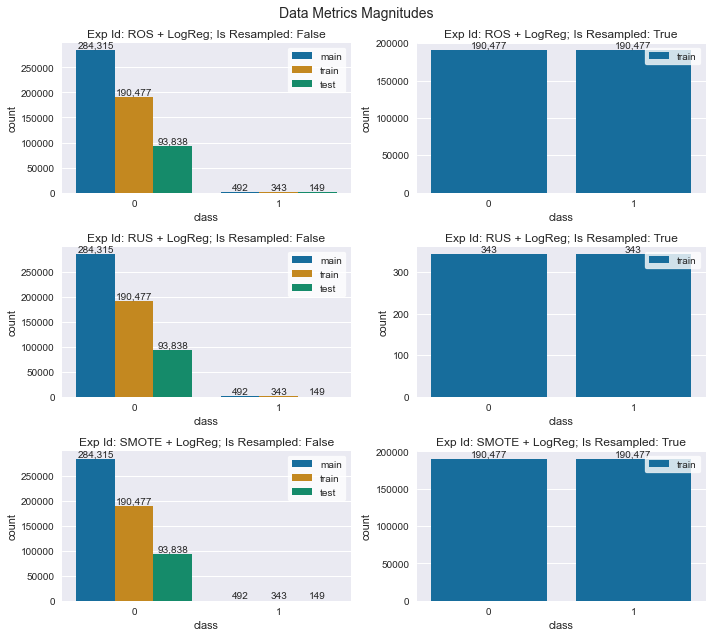

In [6]:
_ = plt.figure(figsize=[10, 9])
plt.suptitle('Data Metrics Magnitudes', fontsize=14)

for i, exp in enumerate(df_data['exp_id'].unique()[:3]):
    data = df_data[df_data['exp_id'] == exp]
    
    index = (i * 2) + 1
    
    plt.subplot(3,2,index)
    ros_log_original = data[~data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_original, 
        x='class', 
        y='count',
        hue='subset',
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{int(value):,}' for value in container.datavalues]
        ax.bar_label(container, labels)
    ax.set_ylabel('count')
    plt.title(f'Exp Id: {exp}; Is Resampled: False')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

    plt.subplot(3,2,index+1)
    ros_log_resampled = data[data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_resampled, 
        x='class', 
        y='count',
        hue='subset',
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{int(value):,}' for value in container.datavalues]
        ax.bar_label(container, labels)
    ax.set_ylabel('count')
    plt.title(f'Exp Id: {exp}; Is Resampled: True')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

plt.tight_layout()

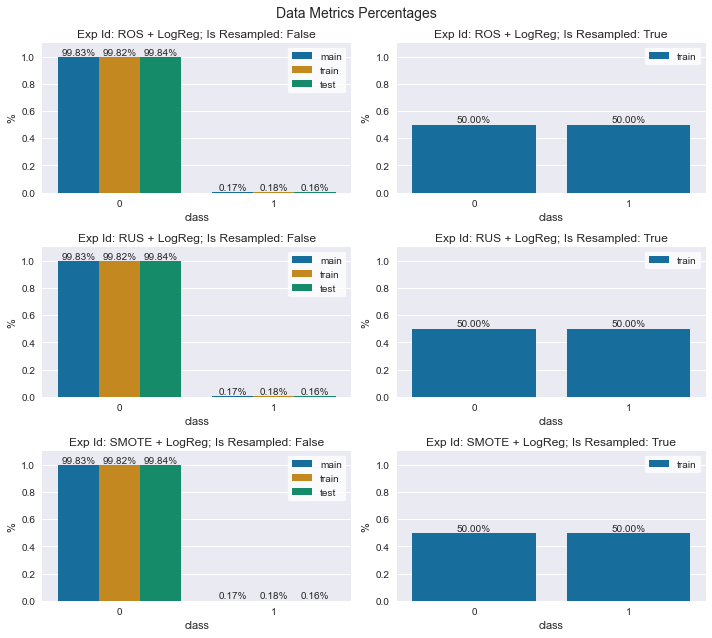

In [7]:
_ = plt.figure(figsize=[10, 9])
plt.suptitle('Data Metrics Percentages', fontsize=14)

for i, exp in enumerate(df_data['exp_id'].unique()[:3]):
    data = df_data[df_data['exp_id'] == exp]
    
    index = (i * 2) + 1
    
    plt.subplot(3,2,index)
    ros_log_original = data[~data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_original, 
        x='class', 
        y='percent',
        hue='subset',
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{value:.2f}%' for value in container.datavalues*100]
        ax.bar_label(container, labels)
    ax.set_ylabel('%')
    plt.ylim([0, 1.1])
    plt.title(f'Exp Id: {exp}; Is Resampled: False')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

    plt.subplot(3,2,index+1)
    ros_log_resampled = data[data['is_resampled']]
    ax = sns.barplot(
        data=ros_log_resampled, 
        x='class', 
        y='percent',
        hue='subset',
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{value:.2f}%' for value in container.datavalues*100]
        ax.bar_label(container, labels)
    ax.set_ylabel('%')
    plt.ylim([0, 1.1])
    plt.title(f'Exp Id: {exp}; Is Resampled: True')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')

plt.tight_layout()

## Basic Model Metrics <a class="anchor" id="2-bullet"></a>

In [8]:
data_to_create_df = [record['message']['data'] for record in raw_model_data['result']]
df_model_metric = pd.DataFrame(data_to_create_df)

In [9]:
df_model_metric.drop_duplicates(subset='f_score', keep='first', inplace=True)

for exp in ['LogReg', 'RanFor']:
    mask = (~df_model_metric['is_resampled']) & (df_model_metric['exp_id'].str.contains(exp))
    df_model_metric.loc[mask, 'exp_id'] = exp

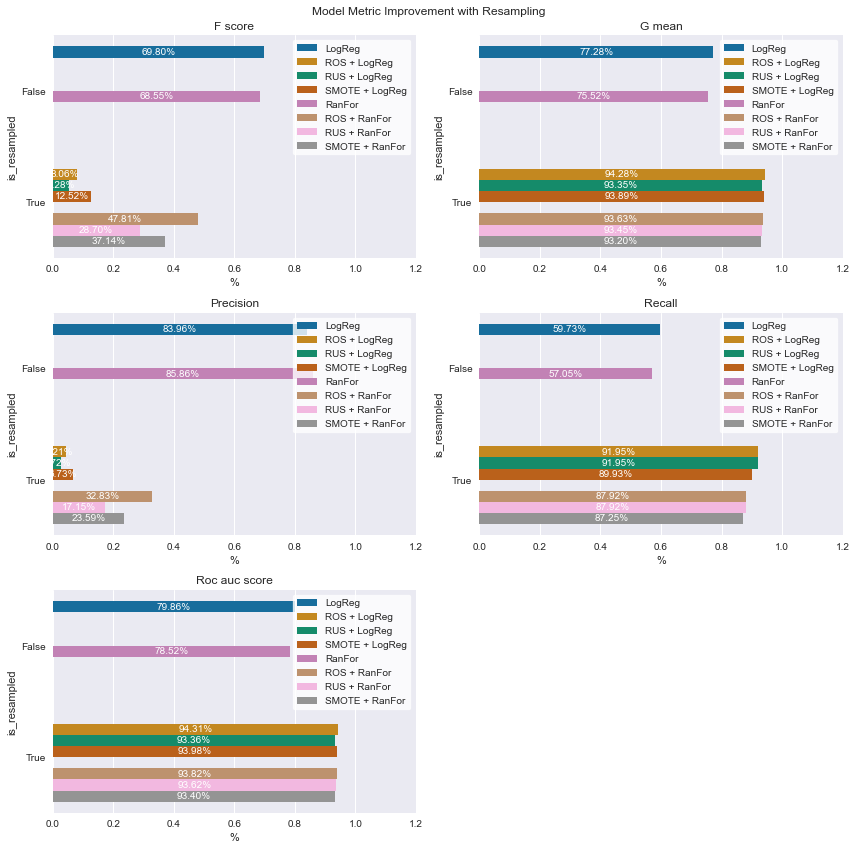

In [10]:
_ = plt.figure(figsize=[12,12])
plt.suptitle('Model Metric Improvement with Resampling')

metric_list = df_model_metric.select_dtypes(include='float64').columns

for i, metric in enumerate(metric_list):
    plt.subplot(3, 2, i+1)
    ax = sns.barplot(
        data=df_model_metric,
        x=metric,
        y='is_resampled',
        hue='exp_id',
        palette='colorblind',
        orient='h')
    for container in ax.containers:
        labels = [f'{value:.2f}%' for value in container.datavalues*100]
        ax.bar_label(container, labels, label_type='center', color='white')
    ax.set_xlabel('%')
    plt.xlim([0,1.2])
    plt.title(metric.replace('_', ' ').capitalize())
    legend = plt.legend(loc='upper right', frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')
  
plt.tight_layout()

## Cross Model Metrics <a class="anchor" id="3-bullet"></a>

In [11]:
cross_data = [record['message']['data'] for record in raw_cross_data['result']]

In [12]:
df = pd.DataFrame()
for cross_record in cross_data:
    df_cross = pd.DataFrame(cross_record)
    df = pd.concat([df, df_cross], ignore_index=True)
    
assert df.shape[0] == cross_data[0].get('fit_time').__len__() * cross_data.__len__()
assert df.shape[1] == cross_data[0].__len__()

df_cross = df.melt(id_vars=['exp_id'], var_name="metrics", value_name="scores")

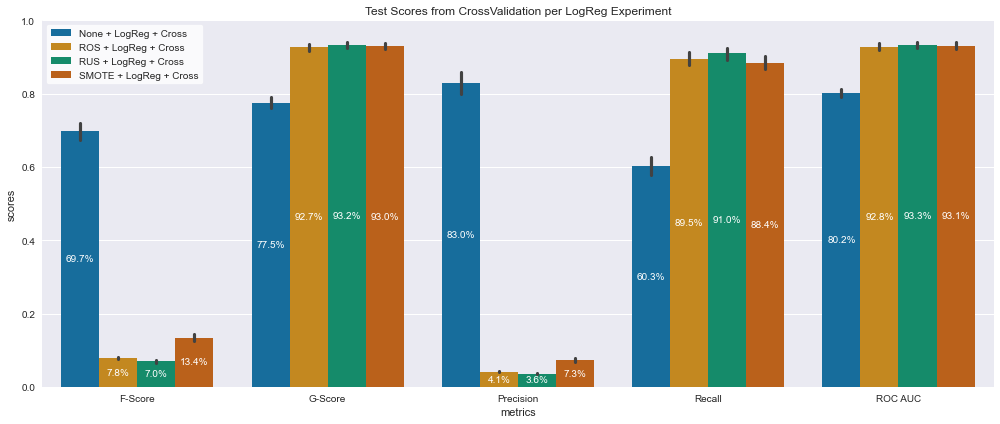

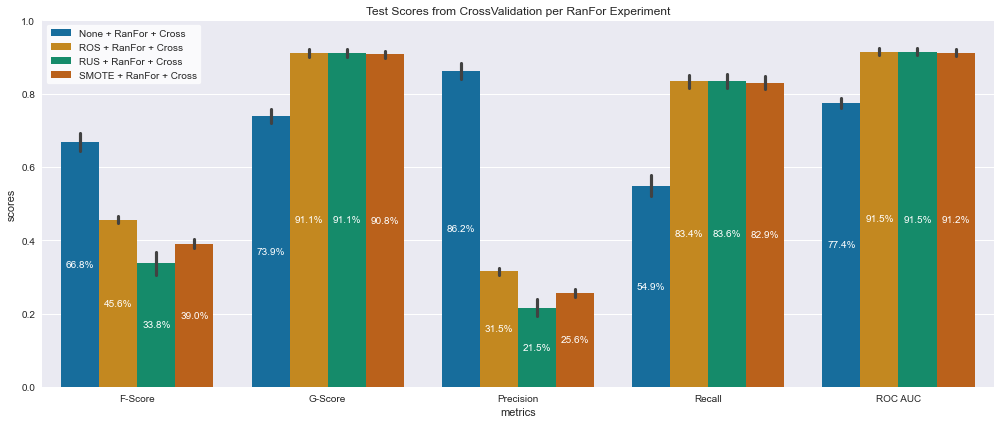

In [13]:
## LogReg
_ = plt.figure(figsize=[14,6])
exp_condition = df_cross['exp_id'].str.contains('LogReg')
metric_condition = ~((df_cross['metrics'].str.contains('fit_time')) | 
                     (df_cross['metrics'].str.contains('score_time')))
mask = exp_condition & metric_condition

ax = sns.barplot(
    data=df_cross[mask],
    x='metrics', 
    y='scores',
    hue='exp_id',
    palette='colorblind')
for container in ax.containers:
    labels = [f'{value:.1f}%' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='center', color='white')
plt.xticks(range(5), ['F-Score', 'G-Score', 'Precision', 'Recall', 'ROC AUC'])
plt.legend(loc='upper left', frameon=True).get_frame().set_color('white')
plt.ylim([0,1])
plt.title('Test Scores from CrossValidation per LogReg Experiment')
plt.tight_layout()


## RanFor
_ = plt.figure(figsize=[14,6])
exp_condition = df_cross['exp_id'].str.contains('RanFor')
metric_condition = ~((df_cross['metrics'].str.contains('fit_time')) | 
                     (df_cross['metrics'].str.contains('score_time')))
mask = exp_condition & metric_condition

ax = sns.barplot(
    data=df_cross[mask],
    x='metrics', 
    y='scores',
    hue='exp_id',
    palette='colorblind')
for container in ax.containers:
    labels = [f'{value:.1f}%' for value in container.datavalues*100]
    ax.bar_label(container, labels, label_type='center', color='white')
plt.xticks(range(5), ['F-Score', 'G-Score', 'Precision', 'Recall', 'ROC AUC'])
plt.legend(loc='upper left', frameon=True).get_frame().set_color('white')
plt.ylim([0,1])
plt.title('Test Scores from CrossValidation per RanFor Experiment')
plt.tight_layout()

## Grid Search Model Metrics <a class="anchor" id="4-bullet"></a>

In [14]:
grid_data = [record['message']['data'] for record in raw_grid_data['result']]

In [15]:
df = pd.DataFrame()
for grid_record in grid_data:
    df_grid = pd.DataFrame(grid_record)
    df = pd.concat([df, df_grid], ignore_index=True)

df_grid_melt = df.melt(id_vars=['exp_id'], var_name="metrics", value_name="scores")

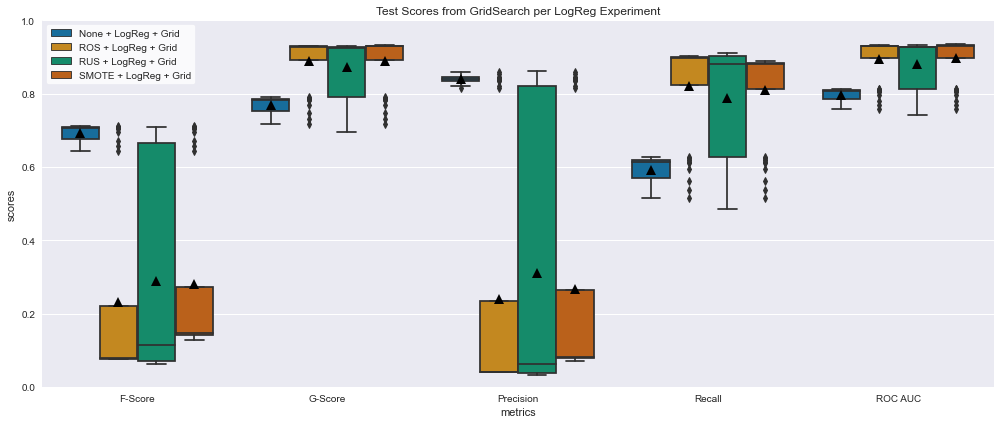

In [16]:
## LogReg
_ = plt.figure(figsize=[14,6])
exp_condition = df_grid_melt['exp_id'].str.contains('LogReg')
metric_condition = df_grid_melt['metrics'].str.contains('mean_test_')
mask = exp_condition & metric_condition
meanprops = {
    'markerfacecolor':'black', 
    'markeredgecolor':'black',
    'markersize':'10',
}
ax = sns.boxplot(
    data=df_grid_melt[mask],
    x='metrics', 
    y='scores',
    hue='exp_id',
    showmeans=True,
    meanprops=meanprops,
    palette='colorblind')
plt.xticks(range(5), ['F-Score', 'G-Score', 'Precision', 'Recall', 'ROC AUC'])
plt.legend(loc='upper left', frameon=True).get_frame().set_color('white')
plt.ylim([0,1])
plt.title('Test Scores from GridSearch per LogReg Experiment')
plt.tight_layout()

In [17]:
metrics = [col for col in df.columns if col.startswith('mean_test_')]
mask = df['param_resampling__sampling_strategy'] != ''
cols = ['exp_id', 'param_resampling__sampling_strategy'] + metrics
df.loc[mask, cols].groupby(['exp_id', 'param_resampling__sampling_strategy']).max()

mean_test_f1  \
exp_id                param_resampling__sampling_strategy                 
ROS + LogReg + Grid   all                                      0.078713   
                      minority                                 0.078713   
                      not majority                             0.078713   
                      not minority                             0.712987   
RUS + LogReg + Grid   all                                      0.152106   
                      minority                                      NaN   
                      not majority                             0.710422   
                      not minority                             0.152106   
SMOTE + LogReg + Grid all                                      0.149890   
                      minority                                 0.149890   
                      not majority                             0.149890   
                      not minority                             0.712987   

                                                           mean_test_geometric_mean_score  \
exp_id                param_resampling__sampling_strategy                                   
ROS + LogReg + Grid   all                                                        0.931372   
                      minority                                                   0.931372   
                      not majority                                               0.931372   
                      not minority                                               0.791812   
RUS + LogReg + Grid   all                                                        0.931219   
                      minority                                                        NaN   
                      not majority                                               0.792842   
                      not minority                                               0.931380   
SMOTE + LogReg + Grid all                                                        0.934004   
                      minority                                                   0.934004   
                      not majority                                               0.934004   
                      not minority                                               0.791812   

                                                           mean_test_precision  \
exp_id                param_resampling__sampling_strategy                        
ROS + LogReg + Grid   all                                             0.041179   
                      minority                                        0.041179   
                      not majority                                    0.041179   
                      not minority                                    0.859072   
RUS + LogReg + Grid   all                                             0.085113   
                      minority                                             NaN   
                      not majority                                    0.862942   
                      not minority                                    0.085113   
SMOTE + LogReg + Grid all                                             0.082080   
                      minority                                        0.082080   
                      not majority                                    0.082080   
                      not minority                                    0.859072   

                                                           mean_test_recall  \
exp_id                param_resampling__sampling_strategy                     
ROS + LogReg + Grid   all                                          0.902430   
                      minority                                     0.902430   
                      not majority                                 0.902430   
                      not minority                                 0.628154   
RUS + LogReg + Grid   all                                          0.911168   
   

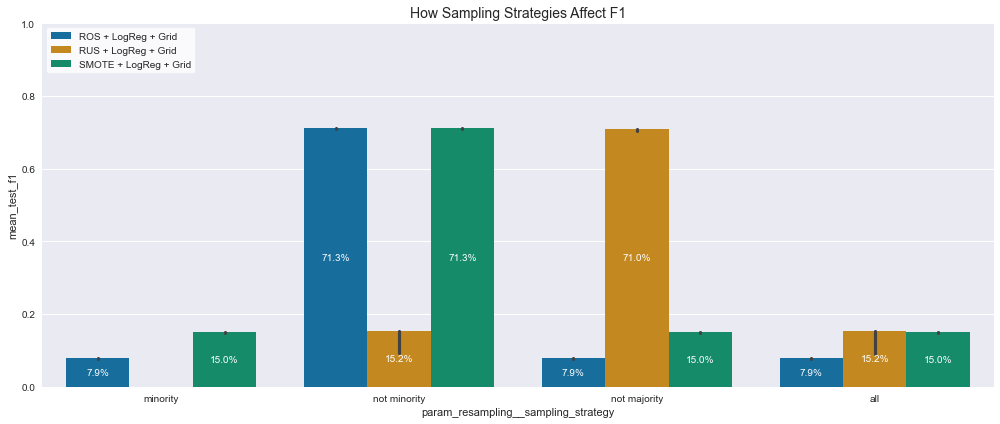

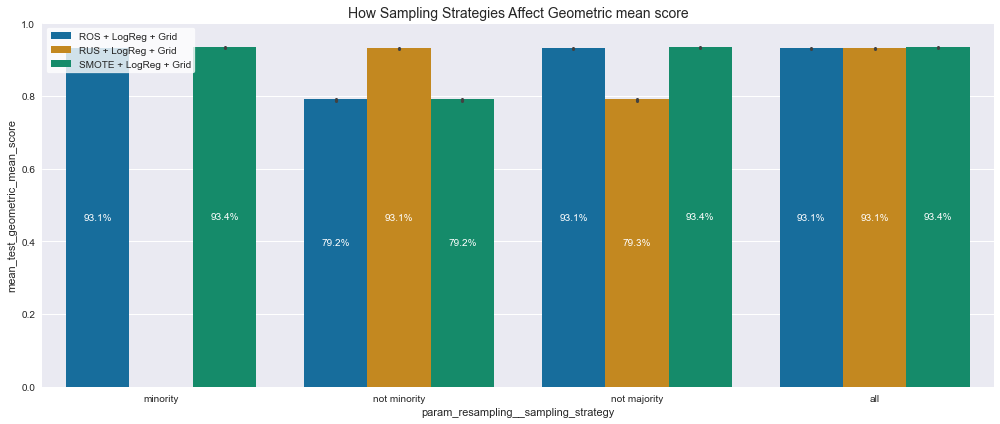

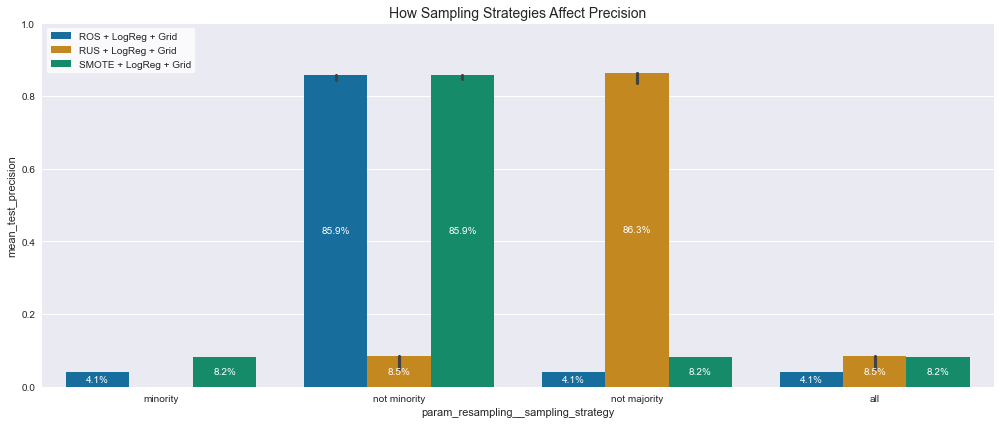

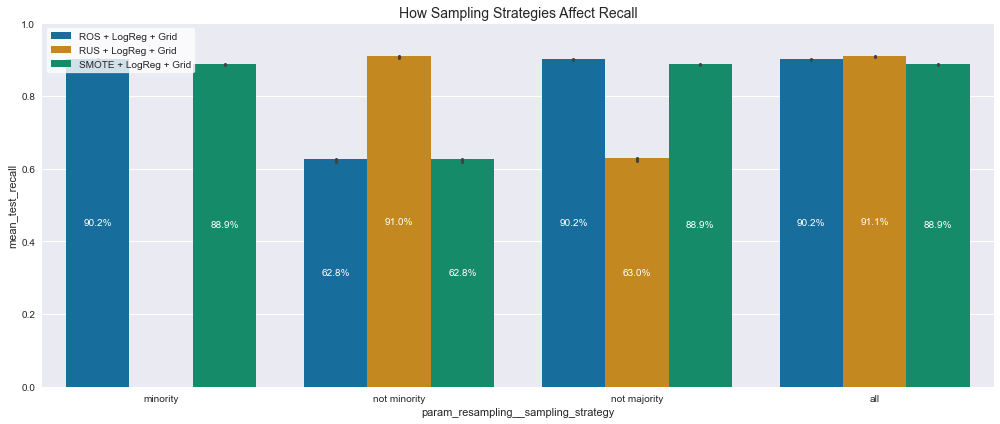

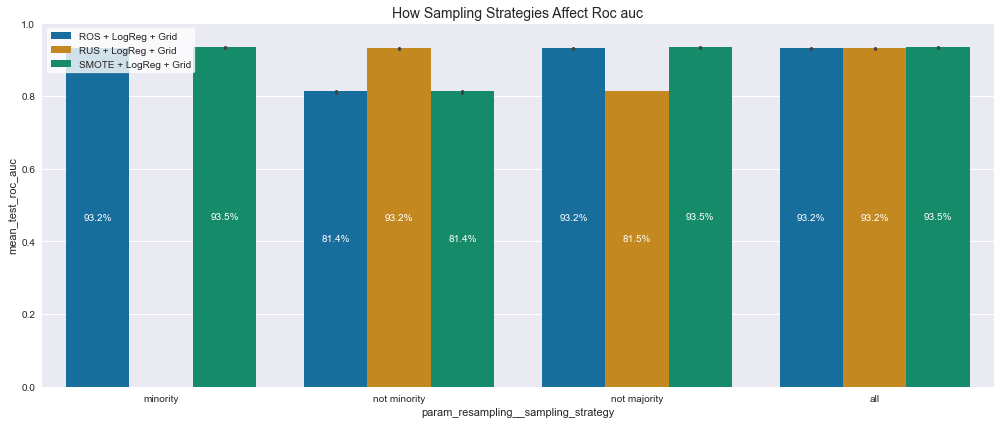

In [18]:
df.loc[df['param_resampling__sampling_strategy'].isnull(), 'param_resampling__sampling_strategy'] = ''

metrics = [col for col in df.columns if col.startswith('mean_test_')]
mask = df['param_resampling__sampling_strategy'] != ''
cols = ['exp_id', 'param_resampling__sampling_strategy'] + metrics

for metric in metrics:
    _ = plt.figure(figsize=[14,6])
    ax = sns.barplot(
        data=df.loc[mask, cols],
        x='param_resampling__sampling_strategy',
        y=metric,
        hue='exp_id',
        estimator=np.max,
        palette='colorblind')
    for container in ax.containers:
        labels = [f'{value:.1f}%' for value in container.datavalues*100]
        ax.bar_label(container, labels, label_type='center', color='white')
    plt.legend(loc='upper left', frameon=True).get_frame().set_color('white')
    pretty_metric = metric.replace('mean_test_', '').replace('_', ' ').capitalize()
    plt.title(f'How Sampling Strategies Affect {pretty_metric}', fontsize=14)
    plt.ylim([0,1])
    plt.tight_layout()

In [19]:
df.loc[mask, cols]

,exp_id,param_resampling__sampling_strategy,mean_test_f1,mean_test_geometric_mean_score,mean_test_precision,mean_test_recall,mean_test_roc_auc
10,ROS + LogReg + Grid,minority,0.078291,0.926259,0.040965,0.892157,0.927039
11,ROS + LogReg + Grid,not minority,0.642277,0.716954,0.859072,0.516091,0.757968
12,ROS + LogReg + Grid,not majority,0.078291,0.926259,0.040965,0.892157,0.927039
13,ROS + LogReg + Grid,all,0.078291,0.926259,0.040965,0.892157,0.927039
14,ROS + LogReg + Grid,minority,0.078713,0.931372,0.041179,0.902430,0.932048
...,...,...,...,...,...,...,...
125,SMOTE + LogReg + Grid,all,0.138567,0.931797,0.075297,0.886360,0.933130
126,SMOTE + LogReg + Grid,minority,0.148041,0.929357,0.081077,0.880499,0.930861
127,SMOTE + LogReg + Grid,not minority,0.709586,0.786560,0.833839,0.619437,0.809606
128,SMOTE + LogReg + Grid,not majority,0.148041,0.929357,0.081077,0.880499,0.930861


In [20]:
cols

['exp_id',
 'param_resampling__sampling_strategy',
 'mean_test_f1',
 'mean_test_geometric_mean_score',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc']

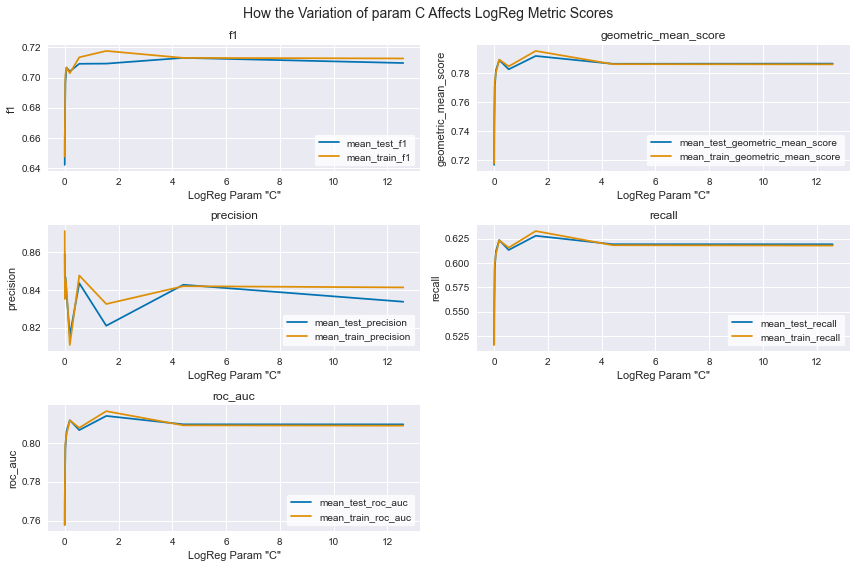

In [21]:
# how C variation does affect LogReg metric scores:
metrics = [col for col in df.columns 
           if col.startswith('mean_test_') 
           or col.startswith('mean_train_')]
mask = df['param_resampling__sampling_strategy'] == ''
cols = ['exp_id', 'param_C'] + metrics

metric_to_plot = [col.replace('mean_test_', '') for col in df.columns 
                  if col.startswith('mean_test_')]
_ = plt.figure(figsize=[12,8])
plt.suptitle('How the Variation of param C Affects LogReg Metric Scores', fontsize=14)
for index, metric in enumerate(metric_to_plot):
    plt.subplot(3,2,index+1)
    sns.lineplot(
        data=df.loc[mask, cols],
        x='param_C',
        y=f'mean_test_{metric}',
        label=f'mean_test_{metric}',
        color=COLORS[0])
    sns.lineplot(
        data=df.loc[mask, cols],
        x='param_C',
        y=f'mean_train_{metric}',
        label=f'mean_train_{metric}',
        color=COLORS[1])
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel('LogReg Param "C"')
    plt.legend(loc='lower right', frameon=True)\
        .get_frame().set_color('white')

plt.tight_layout()